# Gutenberg's books classification

## Merely mounting the google drive folder

In [44]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [45]:
import os
folder_path = "/content/gdrive/MyDrive/NLP - 2024-2/hw04"
os.chdir(folder_path)

## Book loading

In [46]:
# !pip install -q nltk

In [47]:
import re, os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def extract_text_between_markers(file_content):
    """Extrae solo el contenido de libro."""
    start_marker = r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK"
    end_marker = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK"

    start_idx = re.search(start_marker, file_content)
    end_idx = re.search(end_marker, file_content)

    if start_idx and end_idx:
        return file_content[start_idx.end():end_idx.start()]
    return None

def preprocess_text(text):
    """Preprocesa el texto extraído."""
    # Convierte a minúsculas
    text = text.lower()

    # Elimina la puntuación (deja solo palabras y espacios)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokeniza por espacios
    tokens = text.split()

    # Elimina stopwords y palabras de menos de 3 caracteres
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lematiza los tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def load_books_from_directory(directory):
    """Carga y preprocesa todo el listado de libros"""
    all_books = []

    for author in os.listdir(directory):
        author_path = os.path.join(directory, author)
        if os.path.isdir(author_path):
            for book_file in os.listdir(author_path):
                if book_file.endswith('.txt'):
                    book_path = os.path.join(author_path, book_file)
                    with open(book_path, 'r', encoding='utf-8') as f:
                        file_content = f.read()

                    extracted_text = extract_text_between_markers(file_content)

                    if extracted_text:
                        tokens = preprocess_text(extracted_text)
                        all_books.append(tokens)

    return all_books

books_directory = 'books'
preprocessed_books = load_books_from_directory(books_directory)

In [49]:
preprocessed_books[0][-20:]

['violet',
 'hunter',
 'friend',
 'holmes',
 'rather',
 'disappointment',
 'manifested',
 'interest',
 'ceased',
 'centre',
 'one',
 'problem',
 'head',
 'private',
 'school',
 'walsall',
 'believe',
 'met',
 'considerable',
 'success']

## Gensim training

In [50]:
from gensim.models import Word2Vec

In [51]:
def train_word2vec(books, embedding_sizes=[100, 200, 300], save_dir='models'):
    """Entrena los modelos Word2Vec con distintos tamaños de embeddings y los guarda."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for size in embedding_sizes:
        print(f"Entrenando modelo Word2Vec de tamaño {size}...")

        # Train Word2Vec model
        model = Word2Vec(
            sentences=books,
            vector_size=size,
            window=5,
            min_count=1,
            sg=1, # Skipgram
            workers=4,
            epochs=10
        )

        model_filename = f"Books_{size}.model"
        model.save(os.path.join(save_dir, model_filename))
        print(f"Modelo de tamaño {size} guardado como {model_filename}")

embedding_sizes = [100, 200, 300]
train_word2vec(preprocessed_books, embedding_sizes)

Entrenando modelo Word2Vec de tamaño 100...
Modelo de tamaño 100 guardado como Books_100.model
Entrenando modelo Word2Vec de tamaño 200...
Modelo de tamaño 200 guardado como Books_200.model
Entrenando modelo Word2Vec de tamaño 300...
Modelo de tamaño 300 guardado como Books_300.model


## Embeddings visualization

In [52]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [53]:
def plot_embeddings_2d(model, main_word, num_similar=10, reduction_method='tsne'):
    """Grafica los embeddings en 2 dimensiones dado un método de reducción de dimensionalidad en específico."""
    # Obtiene las palabras más similares.
    similar_words = model.wv.most_similar(main_word, topn=num_similar)

    words = [main_word] + [word for word, _ in similar_words]
    word_vectors = np.array([model.wv[word] for word in words])

    # Reducción de dimensionalidad
    if reduction_method == 'pca':
        pca = PCA(n_components=2)
        word_vectors_2d = pca.fit_transform(word_vectors)
    elif reduction_method == 'tsne':
        tsne = TSNE(n_components=2, perplexity=5, random_state=0)
        word_vectors_2d = tsne.fit_transform(word_vectors)

    # Grafica los embeddings
    plt.figure(figsize=(8, 8))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12)

    plt.title(f'Embeddings para "{main_word}" y sus palabras similares')
    plt.grid(True)
    plt.show()

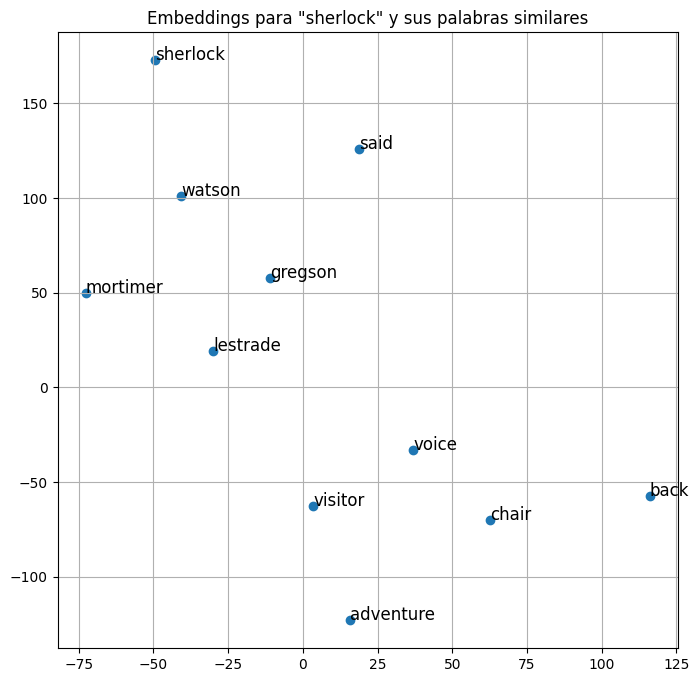

In [54]:
model_path = 'models/Books_100.model'
model = Word2Vec.load(model_path)
plot_embeddings_2d(model, 'sherlock', num_similar=10, reduction_method='tsne')

En casos donde un libro no tenga un personaje principal, por ejemplo algunas obras de Edgar Allan Poe, podemos identificar palabras claves usando TF-IDF y buscar las más similares a estas.

In [55]:
def load_and_preprocess_book(directory, author, book):
    """Carga y preprocesa un libro en específico de un autor."""
    author_path = os.path.join(directory, author)
    book_path = os.path.join(author_path, book)

    if os.path.isfile(book_path):
        with open(book_path, 'r', encoding='utf-8') as f:
            file_content = f.read()

        extracted_text = extract_text_between_markers(file_content)

        if extracted_text:
            tokens = preprocess_text(extracted_text)
            return " ".join(tokens)

    return None

books_directory = 'books'
author = "edgar_allan_poe"
book = "the_fall_of_the_house_of_usher.txt"
preprocessed_book = load_and_preprocess_book(books_directory, author, book)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_top_keywords_from_book(book_text, num_keywords=15):
    """Extrae palabras claves del libro."""

    vectorizer = TfidfVectorizer(max_df=1.0, stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([book_text])

    feature_names = vectorizer.get_feature_names_out()
    tfidf_sum = tfidf_matrix.sum(axis=0)
    keywords = [(feature_names[i], tfidf_sum[0, i]) for i in range(len(feature_names))]

    # Organiza las palabras claves por su puntaje de TF-IDF y retorna el top N
    keywords_sorted = sorted(keywords, key=lambda x: x[1], reverse=True)
    return [keyword for keyword, score in keywords_sorted[:num_keywords]]

top_keywords = extract_top_keywords_from_book(preprocessed_book, num_keywords=15)
print(f"Palabras clave: {top_keywords}")

Palabras clave: ['usher', 'long', 'house', 'door', 'certain', 'character', 'wall', 'portion', 'eye', 'thought', 'wild', 'word', 'day', 'family', 'mind']


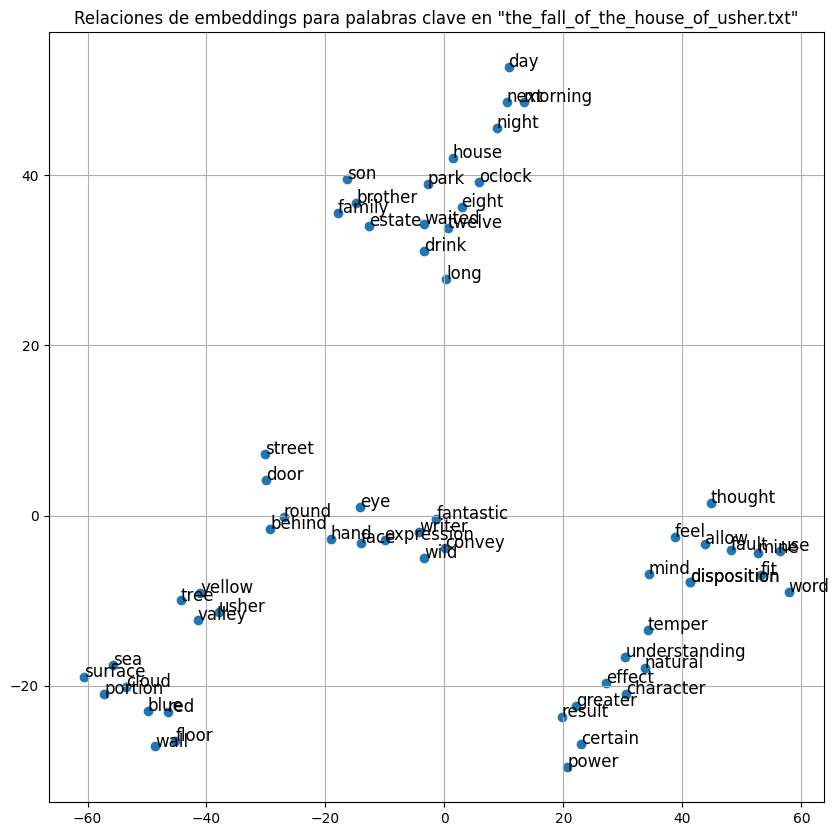

In [57]:
def plot_keywords_relationships(model, keywords, num_similar=10, reduction_method='tsne'):
    """Grafica las relaciones entre las palabras clave y sus palabras más similares."""
    words = []
    for keyword in keywords:
        try:
            similar_words = model.wv.most_similar(keyword, topn=num_similar)
            words += [keyword] + [word for word, _ in similar_words]
        except KeyError:
            print(f"'{keyword}' not in vocabulary")
            continue

    if len(words) == 0:
        print("No valid keywords found in the model vocabulary.")
        return

    word_vectors = np.array([model.wv[word] for word in words])

    # Reducción de dimensionalidad
    if reduction_method == 'pca':
        pca = PCA(n_components=2)
        word_vectors_2d = pca.fit_transform(word_vectors)
    elif reduction_method == 'tsne':
        tsne = TSNE(n_components=2, perplexity=5, random_state=0)
        word_vectors_2d = tsne.fit_transform(word_vectors)

    # Graficar en 2D
    plt.figure(figsize=(10, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12)

    plt.title(f'Relaciones de embeddings para palabras clave en "{book}"')
    plt.grid(True)
    plt.show()

# Ejemplo con embeddings de tamaño 100
model_path = 'models/Books_100.model'
model = Word2Vec.load(model_path)

plot_keywords_relationships(model, top_keywords, num_similar=3, reduction_method='tsne')